# Proyecto: Predicción de Abandono de Clientes Bancarios

## Introducción a los Datasets

### Dataset 1: Predicción de Abandono de Clientes Bancarios (Bank Customer Churn)

**Descripción General:**
Este conjunto de datos contiene información sobre clientes de un banco y su comportamiento, con el objetivo de predecir si un cliente abandonará o no el banco (*churn*). La variable objetivo es `Exited`, que indica si el cliente dejó de ser parte del banco (`1`) o si permaneció (`0`).

**Características del Dataset (Variables relevantes):**
- `CustomerId`: Identificador único del cliente.
- `Surname`: Apellido del cliente.
- `CreditScore`: Puntuación de crédito del cliente.
- `Geography`: País de residencia (ej. Francia, España, Alemania).
- `Gender`: Género del cliente.
- `Age`: Edad del cliente.
- `Tenure`: Años de permanencia en el banco.
- `Balance`: Saldo promedio del cliente.
- `NumOfProducts`: Número de productos que el cliente tiene con el banco.
- `HasCrCard`: Indica si tiene tarjeta de crédito.
- `IsActiveMember`: Indica si el cliente es considerado activo.
- `EstimatedSalary`: Salario estimado del cliente.
- `Exited`: (Variable objetivo) `1` si el cliente se fue del banco, `0` si sigue.

**Objetivo del Proyecto:**
Analizar los factores que influyen en la decisión de un cliente de abandonar el banco. A partir de esto, se puede crear un modelo predictivo que ayude al banco a identificar clientes en riesgo y tomar medidas preventivas de retención.



## 1. Información General
- **Nombre del Proyecto**: 
- **Nombres del Equipo y Roles**:
  - Integrante 1 - Rol
  - Integrante 2 - Rol
- **Resumen del Proyecto**:
Este proyecto busca identificar los factores que influyen en el abandono de clientes usando modelos de analítica de negocios y aprendizaje automático.

## 2. Perspectiva del Negocio
- Contexto del problema y por qué es relevante en el entorno empresarial.
- Impacto potencial de las predicciones.
- Aplicaciones reales en la toma de decisiones.

## 3. Análisis Exploratorio de Datos
- Cargar dataset.
- Revisar estructura de datos.
- Estadísticas descriptivas.
- Visualización inicial.

In [1]:
# Cargar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
# Cargar datos
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [26]:
#Dimension de los datos
dimensiones = pd.DataFrame({
    'Columnas': df.shape[1],
    'Filas': [df.shape[0]],
})
dimensiones


,Columnas,Filas
0,14,10000


In [27]:
# Verificar si hay valores nulos
null_values = df.isnull().sum()
# Verificar tipos de datos
data_types = df.dtypes

# Combinar resultados en un DataFrame para visualización como tabla
data_types = pd.DataFrame({
    'Column': df.columns,
    'Null Values': null_values.values,
    'Data Type': data_types.values
})

# Mostrar la tabla
data_types

,Column,Null Values,Data Type
0,RowNumber,0,int64
1,CustomerId,0,int64
2,Surname,0,object
3,CreditScore,0,int64
4,Geography,0,object
5,Gender,0,object
6,Age,0,int64
7,Tenure,0,int64
8,Balance,0,float64
9,NumOfProducts,0,int64


In [60]:
# Estadísticas generales del dataset
styled_stats = df.describe().style.format(precision=2)
styled_stats

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,15690940.57,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,2500.75,15628528.25,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


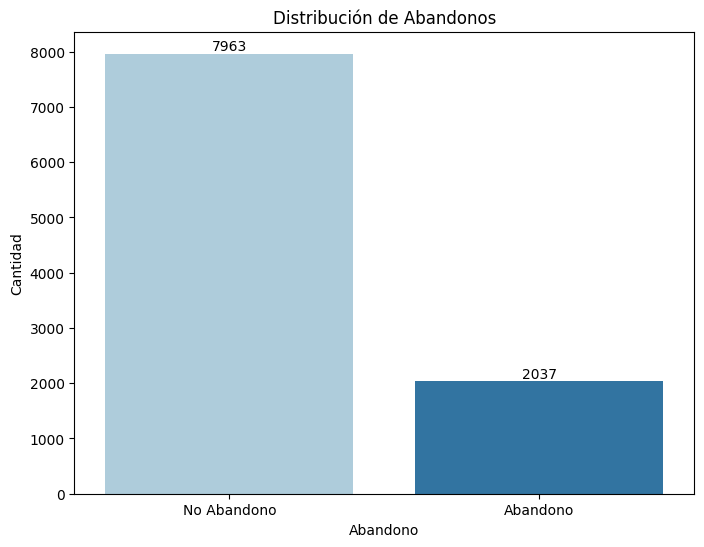

In [ ]:
# Graficar la cantidad de Abandonos 
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Exited', legend=False, palette='Paired', hue="Exited")
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.title('Distribución de Abandonos')
plt.xlabel('Abandono')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['No Abandono', 'Abandono'])
plt.show()


## 4. Preprocesamiento y Limpieza de Datos
- Identificación y manejo de valores nulos o duplicados.
- Transformaciones necesarias.
- Codificación y escalamiento si aplica.

In [ ]:
# Preprocesamiento del dataset
a

## 5. Modelado Predictivo
- División de datos de entrenamiento y prueba.
- Selección de modelos.
- Entrenamiento y validación.

In [ ]:
# Entrenamiento de modelos
a

## 6. Evaluación del Modelo
- Métricas de evaluación.
- Interpretación de resultados.
- Ajustes necesarios.

In [ ]:
# Evaluación del modelo
a

## 7. Visualización de Resultados
- Crear visualizaciones relevantes.
- Mostrar resultados clave.

In [ ]:
# Visualizaciones finales
a

## 8. Conclusiones y Recomendaciones
- Conclusiones generales basadas en el análisis.
- Recomendaciones prácticas para el negocio.

## 9. Documentación Técnica
- Explicación de cómo ejecutar el proyecto paso a paso.
- Herramientas utilizadas con breve descripción y enlaces.
- Repositorio con código/documentación si aplica.

## 10. Recursos Adicionales
- Enlaces útiles.
- Lecturas recomendadas.
- Otros materiales de apoyo.